In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import XGBRegressor 
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from matplotlib.pylab import rcParams

In [2]:
# Define the data types for each column
data_types = {
    'nameFull':'str',
    'bookingNumber':'str',
    'caseNumber':'str',
    'inmateNumber':'str',
    'housing1':'str',
    'housing1a':'str',
    'housing2':'str',
    'housing3': 'str',
    'nameLast':'str',
    'nameFirst':'str',
    'nameMiddle':'str',
    'age': 'float',
    'sex': 'category',
    'race': 'category',
    'eyeColor': 'category',
    'hairColor': 'category',
    'height': 'float',
    'weight': 'float',
    'bond': 'float',
    'bail': 'float',
    'topcharge': 'category',
    'county':'category',
    'Top Poliytical': 'category'
}

# Specify which columns should be parsed as datetime
date_columns = ['date', 'bookingDate', 'dob', 'firstappearance']
df = pd.read_csv('CensusJDI.csv',dtype= data_types, parse_dates = date_columns)
df.dropna(subset=['nameFull'], inplace=True)

In [3]:
import pandas as pd

# Sort the dataset by 'nameFull' and 'firstappearance'
df = df.sort_values(['nameFull', 'firstappearance'])

# Calculate the difference between 'date' and the next 'firstappearance' for each individual
df['time_gap'] = df.groupby('nameFull')['firstappearance'].shift(-1) - df['date']

# Convert the 'time_gap' column to string
df['time_gap'] = df['time_gap'].astype(str)
df['time_gap'] = df['time_gap'].str.replace(' days', '', regex=False)

# Replace "NaT" with 0 in the 'time_gap' column
df['time_gap'] = df['time_gap'].replace('NaT', 0)

# Convert the 'time_gap' column to integers
df['time_gap'] = df['time_gap'].astype(int)

incarceration_count = {}

for index, row in df.iterrows():
    name = str(row['nameFull']).strip() if not pd.isna(row['nameFull']) else None
    if name:
        if name in incarceration_count:
            incarceration_count[name] += 1
        else:
            incarceration_count[name] = 1

# Create a new column 'incarcerated_counts' based on the counts
df['incarcerated_counts'] = df['nameFull'].apply(lambda x: incarceration_count.get(str(x).strip(), 0) 
                                                 if not pd.isna(x) else 0)

# Add a new column reincarcerated base on reincarcerated_counts
df['reincarceration'] = df['incarcerated_counts'].apply(lambda x: 1 if x > 1 else 0)
display(df)

,nameFull,bookingNumber,bookingDate,caseNumber,inmateNumber,housing1,housing1a,housing2,housing3,nameLast,...,Male Unemp %,Female Unemp %,LTHS Unemp %,HS Unemp %,SC/AD Unemp %,Bach./Higher Unemp %,Top Political,time_gap,incarcerated_counts,reincarceration
428320,(J) BENJAMIN HAYES,NaN,2022-09-24,NaN,202201668.0,Napa Co. Jail,NaN,NaN,NaN,NaN,...,4.5,4.7,5.7,3.6,4.3,3.4,D,0,1,0
282037,A ALEXANDER BARRY,6099253.0,NaT,NaN,NaN,Unknown,NaN,NaN,NaN,barry,...,6.5,6.8,6.8,6.9,6.6,5.0,D,0,1,0
206843,A D WEBB,so2294642,NaT,NaN,NaN,Kern County Central Receiving Facility; Kern C...,NaN,NaN,NaN,webb,...,8.4,8.2,10.0,9.9,6.9,2.6,R,450,2,1
223478,A D WEBB,so2322685,NaT,NaN,NaN,Kern County Central Receiving Facility; Kern C...,NaN,NaN,NaN,webb,...,8.4,8.2,10.0,9.9,6.9,2.6,R,0,2,1
230145,A D WEBB JR,so2334382,NaT,NaN,NaN,Kern County Central Receiving Facility; Kern C...,NaN,NaN,NaN,webb,...,8.4,8.2,10.0,9.9,6.9,2.6,R,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453474,ZYRC DAVIS JR,202123900,2021-06-17,210016757,NaN,robert presley detention cente,NaN,NaN,23c8,NaN,...,6.3,7.1,7.9,7.3,5.7,3.8,D,0,1,0
332556,ZYRON NEWHOUSE,6285273,NaT,NaN,40113763,Unknown,NaN,NaN,NaN,newhouse,...,6.5,6.8,6.8,6.9,6.6,5.0,D,0,1,0
411754,ZYSEAN RAY WAFER,22-003686,2022-08-16,NaN,41599,Kings Co. Jail; Kings County Branch Jail,NaN,NaN,NaN,NaN,...,7.7,10.0,12.9,8.3,7.3,3.6,R,17,2,1
411914,ZYSEAN RAY WAFER,22-004084,NaT,NaN,41599,Kings Co. Jail; Kings County Branch Jail,NaN,NaN,NaN,wafer,...,7.7,10.0,12.9,8.3,7.3,3.6,R,0,2,1


# Average Number of Incarceration Spells

In [4]:
# Calculate the total reincarcerated counts for each county
county_reincarcerated_counts = df.groupby('county')['incarcerated_counts'].sum()

# Calculate the total counts of individuals for each county
county_total_counts = df.groupby('county')['nameFull'].nunique()

# Calculate the average reincarcerated count for each county
average_reincarcerated_count_by_county = county_reincarcerated_counts / county_total_counts

# Print the results
print("Average Incarceration count for each county:")
print(average_reincarcerated_count_by_county)

Average Incarceration count for each county:
county
Monterey           3.415386
Santa Cruz         5.615003
Tulare             5.560391
Madera             5.389382
Calaveras          3.333333
San Francisco      3.829577
Marin              4.092581
Shasta             5.129695
Merced             4.409096
Santa Barbara      3.505101
Orange             5.124214
Sutter             3.556206
Kern               3.759479
Lake               5.490174
San Mateo          4.302597
Los Angeles        5.086586
Mono               3.511509
Placer             3.174042
Amador             4.144836
El Dorado          2.590251
Inyo               4.177024
Kings              4.263839
Humboldt           3.181911
Mendocino          4.307346
Napa               6.003629
Solano             3.884501
San Luis Obispo    2.831858
Riverside          3.756576
Yuba               4.516695
Fresno             5.295048
Siskiyou           5.291367
Mariposa           3.227191
Nevada             5.370525
Tehama             2.625

In [5]:
# Calculate the number of unique nameFull values (unique individuals)
total_individual_counts = df['nameFull'].nunique()

# Calculate the total reincarcerated counts for the 35 counties
total_reincarcerated_counts = df['incarcerated_counts'].sum()

# Calculate the average reincarcerated count for the 35 counties
average_reincarcerated_count = total_reincarcerated_counts / total_individual_counts

print("Average Number of Incarceration Spells:", average_reincarcerated_count)

Average Number of Incarceration Spells: 4.938223715138893


# Average Duration out of Jails

In [6]:
# Calculate the total reincarcerated counts for each county
county_time_gap = df.groupby('county')['time_gap'].sum()

# Calculate the total counts of individuals for each county
county_total = df.groupby('county')['nameFull'].nunique()

# Calculate the average reincarcerated count for each county
average_time_gap_by_county = county_time_gap / county_total

# Print the results
print("Average Duration out of Jails for each county:")
print(average_time_gap_by_county)

Average Duration out of Jails for each county:
county
Monterey            92.136767
Santa Cruz         119.015809
Tulare             148.108605
Madera              97.508333
Calaveras           53.198490
San Francisco       59.117716
Marin               90.529516
Shasta             167.506211
Merced             113.492916
Santa Barbara       90.456639
Orange              92.842998
Sutter              62.088993
Kern                71.296311
Lake               155.054802
San Mateo           88.116778
Los Angeles         28.663508
Mono                44.439898
Placer              86.217684
Amador             109.084383
El Dorado           85.527037
Inyo                71.459510
Kings              124.975473
Humboldt            62.246951
Mendocino           64.848576
Napa               135.056777
Solano              88.853622
San Luis Obispo     26.076696
Riverside           51.495449
Yuba               134.268597
Fresno             130.369039
Siskiyou           125.470709
Mariposa        

In [7]:
# Calculate the average reincarcerated count for the 35 counties
average_duration_out_of_jails = average_time_gap_by_county.sum() / 35

print("Average Duration out of Jails:", average_duration_out_of_jails)

Average Duration out of Jails: 94.81836412408124


# PCA for features selection

In [12]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Convert date-related columns to datetime
#date_columns = ['bookingDate', 'dob', 'firstappearance', 'date']
#for col in date_columns:
    #df[col] = pd.to_datetime(df[col], errors='coerce')

# Select the relevant columns for PCA and XGBoost
selected_columns = ['age', 'dob', 'sex', 'race',
       'eyeColor', 'hairColor', 'height', 'weight', 'bond', 'bail',
       'topcharge', 'firstappearance', 'county', 'date', 'incarcerated_days',
       'Population', 'Asian Pop', 'Black Pop', 'Hispanic Pop', 'White Pop',
       'Native Pop', 'Multi-Race Pop', 'Other Pop', 'Avg Hsld Size',
       'Avg Fam Size', 'Owned Housing', 'Rented Housing', 'Health Cov',
       'No Health Cov', 'Med Monthly Housing', 'Poverty %', 'Male Poverty %',
       'Female Poverty %', 'White Poverty %', 'Black Poverty %',
       'Native Poverty %', 'Asian Poverty %', 'Other Poverty %',
       'Hispanic Poverty %', 'Multi-Race Poverty %', 'Black Unemp %',
       'Native Unemp %', 'Asian Unemp %', 'Other Unemp %',
       'Multi-Race Unemp %', 'Hispanic Unemp %', 'White Unemp %',
       'Male Unemp %', 'Female Unemp %', 'LTHS Unemp %', 'HS Unemp %',
       'SC/AD Unemp %', 'Bach./Higher Unemp %', 'Top Political']

# Extract the selected columns and standardize the data
X = df[selected_columns].copy()
X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric
X.fillna(0, inplace=True)  # Handle missing values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
n_components = 2  # You can choose the number of principal components
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(X_scaled)

# Access the loadings (coefficients) for each feature in the principal components
loadings = pca.components_

# Create a DataFrame to show the feature loadings for each component
loadings_df = pd.DataFrame(data=loadings, columns=X.columns, index=['PC1', 'PC2'])

In [13]:
from sklearn.decomposition import PCA
import pandas as pd

# Find the principal component with the highest loading for each variable
max_loading_components = loadings_df.abs().idxmax()

# Print the results
print("Variable-to-Principal Component Mapping:")
print(max_loading_components)

Variable-to-Principal Component Mapping:
age                     PC2
dob                     PC2
sex                     PC2
race                    PC2
eyeColor                PC2
hairColor               PC2
height                  PC2
weight                  PC1
bond                    PC2
bail                    PC2
topcharge               PC2
firstappearance         PC2
county                  PC1
date                    PC2
incarcerated_days       PC2
Population              PC2
Asian Pop               PC2
Black Pop               PC2
Hispanic Pop            PC2
White Pop               PC2
Native Pop              PC2
Multi-Race Pop          PC2
Other Pop               PC1
Avg Hsld Size           PC2
Avg Fam Size            PC2
Owned Housing           PC2
Rented Housing          PC2
Health Cov              PC2
No Health Cov           PC2
Med Monthly Housing     PC1
Poverty %               PC1
Male Poverty %          PC1
Female Poverty %        PC1
White Poverty %         PC1
Black P

### Interpretation:
- PC1 seems to capture features related to various socio-economic factors and political indicators.
- PC2 captures features related to demographic information, incarceration details, and population statistics.

### PCA with One-hot Encoding Categorical Variables

In [12]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df is your original DataFrame

# Convert date-related columns to datetime
# date_columns = ['bookingDate', 'dob', 'firstappearance', 'date']
# for col in date_columns:
#     df[col] = pd.to_datetime(df[col], errors='coerce')

# Select the relevant columns for PCA and XGBoost
selected_columns = ['age', 'dob', 'sex', 'race',
       'eyeColor', 'hairColor', 'height', 'weight', 'bond', 'bail',
       'topcharge', 'firstappearance', 'county', 'date', 'incarcerated_days',
       'Population', 'Asian Pop', 'Black Pop', 'Hispanic Pop', 'White Pop',
       'Native Pop', 'Multi-Race Pop', 'Other Pop', 'Avg Hsld Size',
       'Avg Fam Size', 'Owned Housing', 'Rented Housing', 'Health Cov',
       'No Health Cov', 'Med Monthly Housing', 'Poverty %', 'Male Poverty %',
       'Female Poverty %', 'White Poverty %', 'Black Poverty %',
       'Native Poverty %', 'Asian Poverty %', 'Other Poverty %',
       'Hispanic Poverty %', 'Multi-Race Poverty %', 'Black Unemp %',
       'Native Unemp %', 'Asian Unemp %', 'Other Unemp %',
       'Multi-Race Unemp %', 'Hispanic Unemp %', 'White Unemp %',
       'Male Unemp %', 'Female Unemp %', 'LTHS Unemp %', 'HS Unemp %',
       'SC/AD Unemp %', 'Bach./Higher Unemp %', 'Top Political', 
                   'time_gap','reincarceration', 'incarcerated_counts']

# Extract the selected columns
X = df[selected_columns].copy()

# Convert categorical columns to one-hot encoding
categorical_columns = ['sex', 'race', 'eyeColor', 'hairColor', 'county', 'topcharge', 'Top Political']
X = pd.get_dummies(X, columns=categorical_columns)

# Convert to numeric and handle missing values
X = X.apply(pd.to_numeric, errors='coerce')  
X.fillna(0, inplace=True)  

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
n_components = 2  
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(X_scaled)

# Access the loadings (coefficients) for each feature in the principal components
loadings = pca.components_

# Create a DataFrame to show the feature loadings for each component
loadings_df = pd.DataFrame(data=loadings, columns=X.columns, index=['PC1', 'PC2'])

# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Find the principal component with the highest loading for each variable
max_loading_components = loadings_df.abs().idxmax()

# Print the results
print("Variable-to-Principal Component Mapping:")
print(max_loading_components)

# Reset pandas display options to the default values if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

Variable-to-Principal Component Mapping:
age                       PC2
dob                       PC2
height                    PC2
weight                    PC2
bond                      PC2
bail                      PC2
firstappearance           PC2
date                      PC2
incarcerated_days         PC2
Population                PC2
Asian Pop                 PC1
Black Pop                 PC2
Hispanic Pop              PC1
White Pop                 PC2
Native Pop                PC2
Multi-Race Pop            PC2
Other Pop                 PC1
Avg Hsld Size             PC1
Avg Fam Size              PC2
Owned Housing             PC2
Rented Housing            PC2
Health Cov                PC2
No Health Cov             PC2
Med Monthly Housing       PC1
Poverty %                 PC1
Male Poverty %            PC1
Female Poverty %          PC1
White Poverty %           PC1
Black Poverty %           PC1
Native Poverty %          PC1
Asian Poverty %           PC1
Other Poverty %           PC1

Principal Component 1 (PC1):
1. Significant Contributors:

    - Asian Pop, Hispanic Pop, Other Pop, Avg Hsld Size, Avg Fam Size, Med Monthly Housing, Poverty %, Male Poverty %, Female Poverty %, White Poverty %, Black Poverty %, Native Poverty %, Asian Poverty %, Other Poverty %, Hispanic Poverty %, Multi-Race Poverty %, Black Unemp %, Native Unemp %, Asian Unemp %, Other Unemp %, Multi-Race Unemp %, Hispanic Unemp %, White Unemp %, Male Unemp %, Female Unemp %, LTHS Unemp %, HS Unemp %, SC/AD Unemp %, county

2. Interpretation
    - PC1 seems to capture socio-economic and demographic characteristics, including population statistics, housing information, poverty rates, unemployment rates, and county demographics.

Principal Component 2 (PC2):
1. Significant Contributors:

    - Age, dob, height, weight, bond, bail, firstappearance, date, incarcerated_days, Population, Black Pop, White Pop, Native Pop, Multi-Race Pop, Owned Housing, Rented Housing, Health Cov, No Health Cov, Bach./Higher Unemp %, sex, race, eyeColor, hairColor, topcharge, Top Political

2. Interpretation:

    - PC2 appears to capture a mix of demographic information, legal details (such as top charges), and political affiliation.

Note:
- PC1 is associated with socio-economic and demographic factors.
- PC2 seems to capture a combination of demographic, legal, and political 

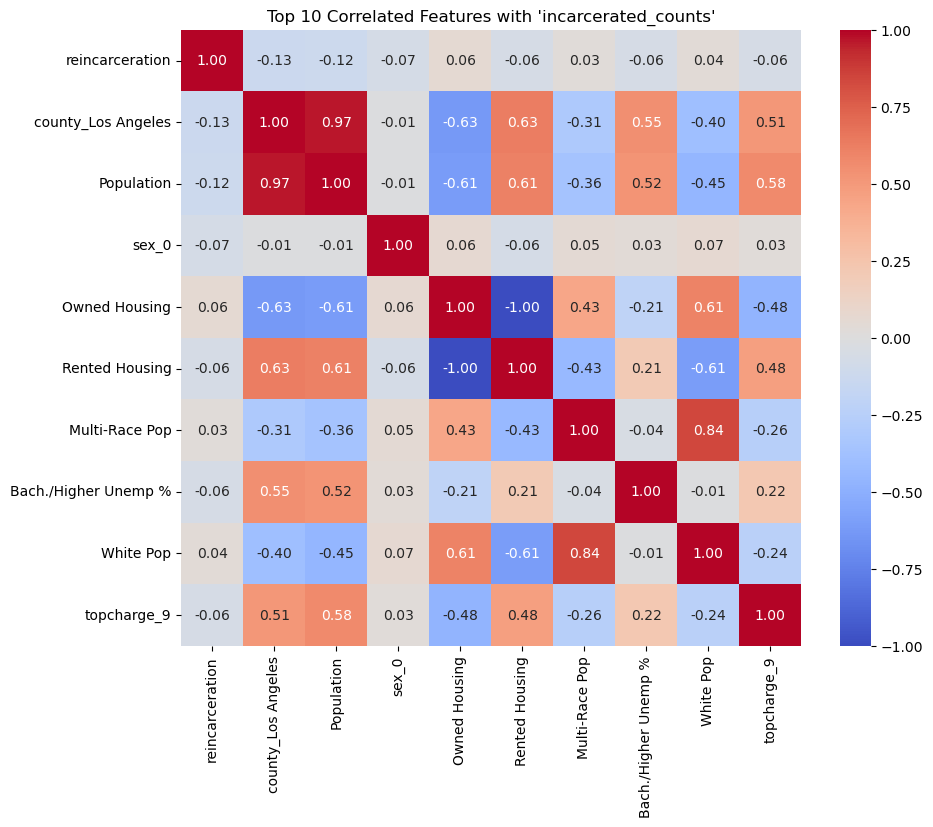

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
features = ['age', 'dob', 'sex', 'race', 'eyeColor', 'hairColor', 'height', 'weight', 'bond', 'bail',
            'topcharge', 'firstappearance', 'county', 'date', 'incarcerated_days',
            'Population', 'Asian Pop', 'Black Pop', 'Hispanic Pop', 'White Pop', 'Native Pop',
            'Multi-Race Pop', 'Other Pop',
            'Avg Hsld Size', 'Avg Fam Size', 'Owned Housing', 'Rented Housing',
            'Health Cov', 'No Health Cov',
            'Med Monthly Housing',
            'Poverty %', 'Male Poverty %', 'Female Poverty %', 'White Poverty %', 'Black Poverty %',
            'Native Poverty %', 'Asian Poverty %', 'Other Poverty %', 'Hispanic Poverty %',
            'Multi-Race Poverty %',
            'Black Unemp %', 'Native Unemp %', 'Asian Unemp %', 'Other Unemp %', 'Multi-Race Unemp %',
            'Hispanic Unemp %', 'White Unemp %', 'Male Unemp %', 'Female Unemp %', 'LTHS Unemp %',
            'HS Unemp %', 'SC/AD Unemp %', 'Bach./Higher Unemp %',
            'Top Political',
            'time_gap', 'reincarceration', 'incarcerated_counts']

selected_features = df[features].copy()

# One-hot encode categorical variables
selected_features = pd.get_dummies(selected_features, columns=['sex', 'race', 'eyeColor', 'hairColor', 'county', 'topcharge', 'Top Political'])

# Calculate correlation matrix
correlation_matrix = selected_features.corr()

# Extract the top 10 correlated features with 'time_gap'
top_correlated_features = correlation_matrix['incarcerated_counts'].abs().nlargest(11).index[1:]

# Select only the top correlated features
top_correlation_matrix = selected_features[top_correlated_features].corr()

# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap using Seaborn
sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Set the title (optional)
plt.title("Top 10 Correlated Features with 'incarcerated_counts'")

# Show the plot
plt.show()


### PCA with Numeric Categorical Variables

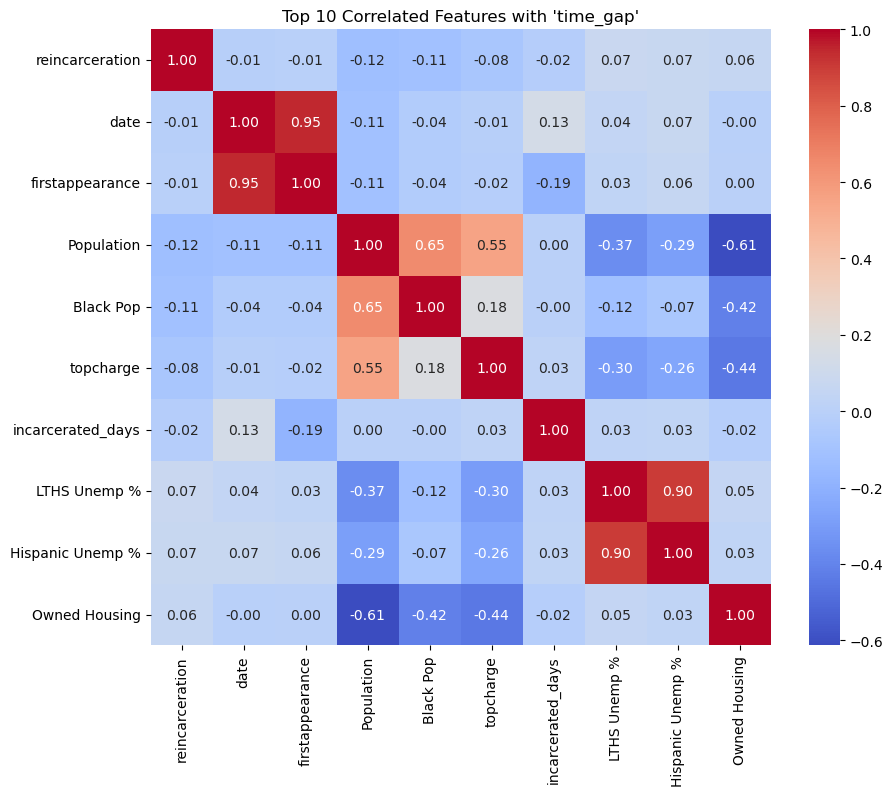

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


features = ['age', 'dob', 'sex', 'race','eyeColor', 'hairColor', 'height', 'weight', 'bond', 'bail',
            'topcharge', 'firstappearance', 'county', 'date', 'incarcerated_days',
            'Population', 'Asian Pop', 'Black Pop', 'Hispanic Pop', 'White Pop','Native Pop', 
            'Multi-Race Pop', 'Other Pop', 
            'Avg Hsld Size','Avg Fam Size', 'Owned Housing', 'Rented Housing', 
            'Health Cov','No Health Cov', 
            'Med Monthly Housing', 
            'Poverty %', 'Male Poverty %','Female Poverty %', 'White Poverty %', 'Black Poverty %',
            'Native Poverty %', 'Asian Poverty %', 'Other Poverty %','Hispanic Poverty %', 
            'Multi-Race Poverty %', 
            'Black Unemp %','Native Unemp %', 'Asian Unemp %', 'Other Unemp %','Multi-Race Unemp %', 
            'Hispanic Unemp %', 'White Unemp %','Male Unemp %', 'Female Unemp %', 'LTHS Unemp %', 
            'HS Unemp %','SC/AD Unemp %', 'Bach./Higher Unemp %', 
            'Top Political', 
            'time_gap','reincarceration', 'incarcerated_counts']

selected_features = df[features].copy()

# Initialize a label encoder
label_encoder = LabelEncoder()
# Assuming 'county' is a column in your DataFrame 'df'
selected_features['county'] = label_encoder.fit_transform(selected_features['county'])
selected_features['Top Political'] = label_encoder.fit_transform(selected_features['Top Political'])

#Calculate correlation matrix
correlation_matrix = selected_features.corr()

# Extract the top 10 correlated features with 'incarcerated_days'
top_correlated_features = correlation_matrix['time_gap'].abs().nlargest(11).index[1:]

# Select only the top correlated features
top_correlation_matrix = selected_features[top_correlated_features].corr()

# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap using Seaborn
sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Set the title (optional)
plt.title("Top 10 Correlated Features with 'time_gap'")

# Save the plot
#plt.savefig('top_correlation_map_features.png', transparent=True)

# Show the plot
plt.show()

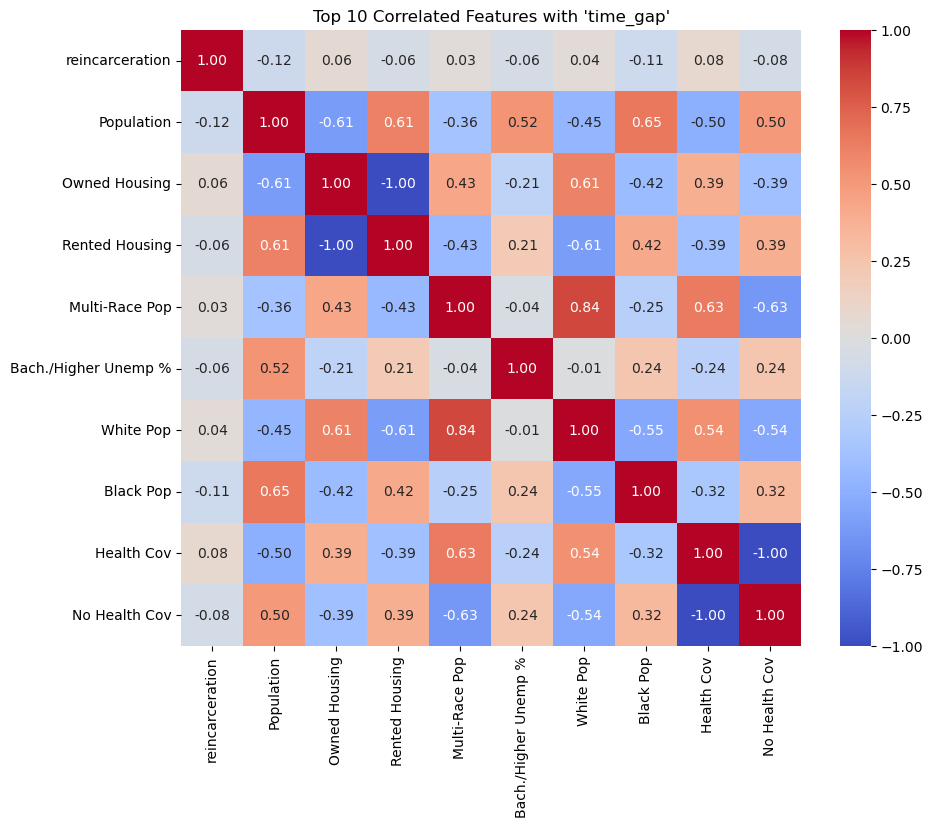

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


features = ['age', 'dob', 'sex', 'race','eyeColor', 'hairColor', 'height', 'weight', 'bond', 'bail',
            'topcharge', 'firstappearance', 'county', 'date', 'incarcerated_days',
            'Population', 'Asian Pop', 'Black Pop', 'Hispanic Pop', 'White Pop','Native Pop', 
            'Multi-Race Pop', 'Other Pop', 
            'Avg Hsld Size','Avg Fam Size', 'Owned Housing', 'Rented Housing', 
            'Health Cov','No Health Cov', 
            'Med Monthly Housing', 
            'Poverty %', 'Male Poverty %','Female Poverty %', 'White Poverty %', 'Black Poverty %',
            'Native Poverty %', 'Asian Poverty %', 'Other Poverty %','Hispanic Poverty %', 
            'Multi-Race Poverty %', 
            'Black Unemp %','Native Unemp %', 'Asian Unemp %', 'Other Unemp %','Multi-Race Unemp %', 
            'Hispanic Unemp %', 'White Unemp %','Male Unemp %', 'Female Unemp %', 'LTHS Unemp %', 
            'HS Unemp %','SC/AD Unemp %', 'Bach./Higher Unemp %', 
            'Top Political', 
            'time_gap','reincarceration', 'incarcerated_counts']

selected_features = df[features].copy()

# Initialize a label encoder
label_encoder = LabelEncoder()
# Assuming 'county' is a column in your DataFrame 'df'
selected_features['county'] = label_encoder.fit_transform(selected_features['county'])
selected_features['Top Political'] = label_encoder.fit_transform(selected_features['Top Political'])

#Calculate correlation matrix
correlation_matrix = selected_features.corr()

# Extract the top 10 correlated features with 'incarcerated_days'
top_correlated_features = correlation_matrix['incarcerated_counts'].abs().nlargest(11).index[1:]

# Select only the top correlated features
top_correlation_matrix = selected_features[top_correlated_features].corr()

# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap using Seaborn
sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Set the title (optional)
plt.title("Top 10 Correlated Features with 'incarcerated_counts'")

# Save the plot
#plt.savefig('top_correlation_map_features.png', transparent=True)

# Show the plot
plt.show()

# Statistical Method for Significant Predictors

In [20]:
from sklearn.preprocessing import LabelEncoder

features = ['age', 'sex', 'race','eyeColor', 'hairColor', 'height', 'weight', 'bond', 'bail',
            'topcharge', 'firstappearance', 'county', 'date', 'incarcerated_days',
            'Population', 'Asian Pop', 'Black Pop', 'Hispanic Pop', 'White Pop','Native Pop', 
            'Multi-Race Pop', 'Other Pop', 
            'Avg Hsld Size','Avg Fam Size', 'Owned Housing', 'Rented Housing', 
            'Health Cov','No Health Cov', 
            'Med Monthly Housing', 
            'Poverty %', 'Male Poverty %','Female Poverty %', 'White Poverty %', 'Black Poverty %',
            'Native Poverty %', 'Asian Poverty %', 'Other Poverty %','Hispanic Poverty %', 
            'Multi-Race Poverty %', 
            'Black Unemp %','Native Unemp %', 'Asian Unemp %', 'Other Unemp %','Multi-Race Unemp %', 
            'Hispanic Unemp %', 'White Unemp %','Male Unemp %', 'Female Unemp %', 'LTHS Unemp %', 
            'HS Unemp %','SC/AD Unemp %', 'Bach./Higher Unemp %', 
            'Top Political'] 
            
            #'time_gap','reincarceration', 'incarcerated_counts']

selected_features = df[features].copy()

#replace nan value in bond and bail with 0
selected_features.loc[:,'bond'].fillna(0, inplace = True)
selected_features.loc[:,'age'].fillna(selected_features['age'].mean(), inplace = True)
selected_features.loc[:,'bail'].fillna(0, inplace = True)

# Convert 'firstappearance' to the year as an integer
selected_features.loc[:,'firstappearance'] = selected_features['firstappearance'].dt.year
selected_features.loc[:,'firstappearance'] = selected_features['firstappearance'].astype(int)
selected_features.loc[:,'date'] = selected_features['date'].dt.year
selected_features.loc[:,'date'] = selected_features['date'].astype(int)

# Convert 'sex' and 'topcharge' to categorical columns
selected_features['sex'] = selected_features['sex'].astype('int')
selected_features['eyeColor'] = selected_features['eyeColor'].astype('int')
selected_features['hairColor'] = selected_features['hairColor'].astype('int')
selected_features['race'] = selected_features['race'].astype('int')
selected_features['topcharge'] = selected_features['topcharge'].astype('int')

# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Assuming 'county' is a column in your DataFrame 'df'
selected_features['county'] = label_encoder.fit_transform(selected_features['county'])
selected_features['Top Political'] = label_encoder.fit_transform(selected_features['Top Political'])

# Perform logistic regression
import statsmodels.api as sm

linear_model = sm.OLS(df['time_gap'], selected_features)
result = linear_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               time_gap   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     1783.
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        09:48:49   Log-Likelihood:            -3.7874e+06
No. Observations:              601261   AIC:                         7.575e+06
Df Residuals:                  601213   BIC:                         7.575e+06
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
age                     -0.2132 

### Interpretation: 

- An R-squared of 0.122 means that approximately 12.2% of the variability in the number of incarcerated days can be explained by the independent variable included in the regression models. 
- The log-likelihood suggests that the model provides a good fit to the data.
- AIC and BIC provide a balance between model fit and complexity. In this case, both AIC and BIC are the same, and the absolute values are not as important as their relative values when comparing different models. Lower AIC and BIC values indicate a better-fitting model with fewer unnecessary parameter

### Significant Predictors:

The predictors with p-values less than 0.05 are typically considered statistically significant. Therefore, all the predictors listed above, except "Sex," "Race," "EyeColor,"Bond"," "Poverty %," and "Hispanic Poverty %," can be considered significant predictors in this analysis.

#### Example way of interpreting p-value in this case: 

County:

- Coefficient: 0.8008
- P-value: 0.001 (which is less than the commonly used significance level of 0.05)
- The positive coefficient for age suggests that as the county increases by one unit, the dependent variable (incarcerated_days) is expected to increase by 0.8008 units. The low p-value indicates that this relationship is statistically significant.


In [22]:
from sklearn.preprocessing import LabelEncoder

features = ['age', 'sex', 'race','eyeColor', 'hairColor', 'height', 'weight', 'bond', 'bail',
            'topcharge', 'firstappearance', 'county', 'date', 'incarcerated_days',
            'Population', 'Asian Pop', 'Black Pop', 'Hispanic Pop', 'White Pop','Native Pop', 
            'Multi-Race Pop', 'Other Pop', 
            'Avg Hsld Size','Avg Fam Size', 'Owned Housing', 'Rented Housing', 
            'Health Cov','No Health Cov', 
            'Med Monthly Housing', 
            'Poverty %', 'Male Poverty %','Female Poverty %', 'White Poverty %', 'Black Poverty %',
            'Native Poverty %', 'Asian Poverty %', 'Other Poverty %','Hispanic Poverty %', 
            'Multi-Race Poverty %', 
            'Black Unemp %','Native Unemp %', 'Asian Unemp %', 'Other Unemp %','Multi-Race Unemp %', 
            'Hispanic Unemp %', 'White Unemp %','Male Unemp %', 'Female Unemp %', 'LTHS Unemp %', 
            'HS Unemp %','SC/AD Unemp %', 'Bach./Higher Unemp %', 
            'Top Political'] 
            
            #'time_gap','reincarceration', 'incarcerated_counts']

selected_features = df[features].copy()

#replace nan value in bond and bail with 0
selected_features.loc[:,'bond'].fillna(0, inplace = True)
selected_features.loc[:,'age'].fillna(selected_features['age'].mean(), inplace = True)
selected_features.loc[:,'bail'].fillna(0, inplace = True)

# Convert 'firstappearance' to the year as an integer
selected_features.loc[:,'firstappearance'] = selected_features['firstappearance'].dt.year
selected_features.loc[:,'firstappearance'] = selected_features['firstappearance'].astype(int)
selected_features.loc[:,'date'] = selected_features['date'].dt.year
selected_features.loc[:,'date'] = selected_features['date'].astype(int)

# Convert 'sex' and 'topcharge' to categorical columns
selected_features['sex'] = selected_features['sex'].astype('int')
selected_features['eyeColor'] = selected_features['eyeColor'].astype('int')
selected_features['hairColor'] = selected_features['hairColor'].astype('int')
selected_features['race'] = selected_features['race'].astype('int')
selected_features['topcharge'] = selected_features['topcharge'].astype('int')

# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Assuming 'county' is a column in your DataFrame 'df'
selected_features['county'] = label_encoder.fit_transform(selected_features['county'])
selected_features['Top Political'] = label_encoder.fit_transform(selected_features['Top Political'])

# Perform logistic regression
import statsmodels.api as sm

linear_model = sm.OLS(df['incarcerated_counts'], selected_features)
result = linear_model.fit()
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     incarcerated_counts   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.003
Method:                  Least Squares   F-statistic:                     41.74
Date:                 Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                         09:52:52   Log-Likelihood:            -2.3129e+06
No. Observations:               601261   AIC:                         4.626e+06
Df Residuals:                   601213   BIC:                         4.627e+06
Df Model:                           47                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
age                   

### Interpretation: 

- An R-squared of 0.003 means that approximately 0.3% of the variability in the number of incarcerated days can be explained by the independent variable included in the regression models. 

In [23]:
from sklearn.linear_model import Lasso

X = selected_features
y = df['time_gap']

lasso_model = Lasso(alpha=0.1)  # You can adjust the regularization strength (alpha)
result = lasso_model.fit(X, y)

# Retrieve the coefficients and their significance
feature_coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_model.coef_})
feature_coef['Significant'] = feature_coef['Coefficient'] != 0

/Users/besocxinh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.221e+09, tolerance: 1.187e+06
  model = cd_fast.enet_coordinate_descent(


In [24]:
print(feature_coef)

                 Feature   Coefficient  Significant
0                    age -2.068551e-01         True
1                    sex  1.084401e+00         True
2                   race -4.353623e-01         True
3               eyeColor -5.503100e-01         True
4              hairColor -5.478838e-01         True
5                 height  5.234076e-01         True
6                 weight  1.474938e-02         True
7                   bond -1.035145e-07         True
8                   bail -2.798648e-06         True
9              topcharge -2.703157e+00         True
10       firstappearance -2.329645e+01         True
11                county -5.426007e-02         True
12                  date -2.417132e+01         True
13     incarcerated_days -1.380280e-01         True
14            Population  1.889531e-07         True
15             Asian Pop  4.679444e-01         True
16             Black Pop -6.135654e+00         True
17          Hispanic Pop -0.000000e+00        False
18          

#### Interpretation

In Lasso regression, the coefficients are penalized to be exactly zero, which leads to feature selection. When the coefficient of a predictor is zero, it means that the predictor is not contributing to the model, and the corresponding feature can be considered as not significant.

### Results 

The significant predictors that are common to both models are:
- 'age', 'sex', 'race', 'eyeColor', 'hairColor', 'height', 'weight',
       'bond', 'bail', 'topcharge', 'firstappearance', 'county', 'date',
       'incarcerated_days', 'Population', 'Asian Pop', 'Black Pop',
       'White Pop',  'Multi-Race Pop', 'Owned Housing',
       'Rented Housing', 'Health Cov', 'No Health Cov', 'Med Monthly Housing',
       'Poverty %', 'Male Poverty %', 'Female Poverty %', 'White Poverty %',
       'Black Poverty %', 'Native Poverty %', 'Asian Poverty %',
       'Other Poverty %', 'Hispanic Poverty %', 'Multi-Race Poverty %',
       'Black Unemp %', 'Native Unemp %', 'Asian Unemp %', 'Other Unemp %',
       'Multi-Race Unemp %', 'Hispanic Unemp %',
       'Male Unemp %', 'LTHS Unemp %', 'HS Unemp %',
       'SC/AD Unemp %', 'Bach./Higher Unemp %', 'Top Political'

These are the predictors that both models agree are significant in explaining the variance in the response variable.

In [29]:
from sklearn.linear_model import Lasso

X = selected_features
y = df['incarcerated_counts']

lasso_model = Lasso(alpha=0.1)  # You can adjust the regularization strength (alpha)
result = lasso_model.fit(X, y)

# Retrieve the coefficients and their significance
feature_coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_model.coef_})
feature_coef['Significant'] = feature_coef['Coefficient'] != 0

In [30]:
print(feature_coef)

                 Feature   Coefficient  Significant
0                    age -7.257301e-03         True
1                    sex  2.713515e-02         True
2                   race -0.000000e+00        False
3               eyeColor  0.000000e+00        False
4              hairColor -0.000000e+00        False
5                 height  2.276726e-02         True
6                 weight -2.833003e-03         True
7                   bond -9.822033e-09         True
8                   bail -2.346618e-07         True
9              topcharge -0.000000e+00        False
10       firstappearance -0.000000e+00        False
11                county -1.883109e-03         True
12                  date -0.000000e+00        False
13     incarcerated_days -4.355595e-04         True
14            Population  1.178629e-07         True
15             Asian Pop  0.000000e+00        False
16             Black Pop -0.000000e+00        False
17          Hispanic Pop  1.451989e-03         True
18          

### Results 

The significant predictors that are common to both models are:
- 'age', 'sex', 'height', 'weight', 'bond', 'bail', 'county',
       'incarcerated_days', 'Population', 'Hispanic Pop', 'Med Monthly Housing',
       'Native Poverty %', 'Asian Poverty %',
       'Other Poverty %', 
       'Black Unemp %',  'Asian Unemp %', 'LTHS Unemp %', 'HS Unemp %'
       
These are the predictors that both models agree are significant in explaining the variance in the response variable.

### Note

Distinguishing between Significant Predictors and Feature Importance
- Context:

    - Significant predictors are often discussed in the context of statistical models and hypothesis testing.
    - Feature importance is a concept more commonly associated with machine learning models.
- Methodology:

    - Significance in statistical models is often determined through hypothesis testing and p-values.
    - Feature importance in machine learning models is computed using various algorithms specific to the model type.
- Interpretation:

    - Significance indicates a meaningful relationship between a predictor and the response variable.
    - Feature importance reflects the contribution of a feature to the overall predictive performance of the model.
    
In practice, if you're working with statistical models, you might talk about significant predictors. In machine learning, especially with ensemble models, you're more likely to discuss feature importance. Both concepts aim to identify variables that are crucial for understanding or predicting the outcome, but they come from different traditions of statistical analysis.

# Build a Mixed-effect (multi-level) model

In [16]:
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf


features = ['age', 'sex', 'race','eyeColor', 'hairColor', 'height', 'weight', 'bond', 'bail',
            'topcharge', 'firstappearance', 'county', 'date', 'incarcerated_days',
            'Population', 'Asian Pop', 'Black Pop', 'Hispanic Pop', 'White Pop','Native Pop', 
            'Multi-Race Pop', 'Other Pop', 
            'Avg Hsld Size','Avg Fam Size', 'Owned Housing', 'Rented Housing', 
            'Health Cov','No Health Cov', 
            'Med Monthly Housing', 
            'Poverty %', 'Male Poverty %','Female Poverty %', 'White Poverty %', 'Black Poverty %',
            'Native Poverty %', 'Asian Poverty %', 'Other Poverty %','Hispanic Poverty %', 
            'Multi-Race Poverty %', 
            'Black Unemp %','Native Unemp %', 'Asian Unemp %', 'Other Unemp %','Multi-Race Unemp %', 
            'Hispanic Unemp %', 'White Unemp %','Male Unemp %', 'Female Unemp %', 'LTHS Unemp %', 
            'HS Unemp %','SC/AD Unemp %', 'Bach./Higher Unemp %', 
            'Top Political', 'reincarceration', 'incarcerated_counts'] 
            
            #'time_gap','reincarceration', 'incarcerated_counts']

selected_features = df[features].copy()
# Replace spaces and special characters with underscores in column names
selected_features.columns = selected_features.columns.str.replace(' ', '_').str.replace('%', 'pct').str.replace('.', '').str.replace('-', '_').str.replace('/','_')

#replace nan value in bond and bail with 0
selected_features.loc[:,'bond'].fillna(0, inplace = True)
selected_features.loc[:,'age'].fillna(selected_features['age'].mean(), inplace = True)
selected_features.loc[:,'bail'].fillna(0, inplace = True)

# Convert 'firstappearance' to the year as an integer
selected_features.loc[:,'firstappearance'] = selected_features['firstappearance'].dt.year
selected_features.loc[:,'firstappearance'] = selected_features['firstappearance'].astype(int)
selected_features.loc[:,'date'] = selected_features['date'].dt.year
selected_features.loc[:,'date'] = selected_features['date'].astype(int)

# Convert 'sex' and 'topcharge' to categorical columns
selected_features['sex'] = selected_features['sex'].astype('int')
selected_features['eyeColor'] = selected_features['eyeColor'].astype('int')
selected_features['hairColor'] = selected_features['hairColor'].astype('int')
selected_features['race'] = selected_features['race'].astype('int')
selected_features['topcharge'] = selected_features['topcharge'].astype('int')

# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Assuming 'county' is a column in your DataFrame 'df'
selected_features['county'] = label_encoder.fit_transform(selected_features['county'])
selected_features['Top_Political'] = label_encoder.fit_transform(selected_features['Top_Political'])

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Create a formula for the model excluding the 'reincarceration' column
formula = 'incarcerated_counts ~ ' + ' + '.join(selected_features.columns.difference(['incarcerated_counts'])) + ' + (1 | county)'

# Fit the mixed-effects model
mixed_model = smf.mixedlm(formula, data=selected_features, groups=selected_features['county'])
result = mixed_model.fit()

# Print the summary
print(result.summary())

/Users/besocxinh/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                         Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        incarcerated_counts
No. Observations:         601261         Method:                    REML               
No. Groups:               35             Scale:                     124.5407           
Min. group size:          500            Log-Likelihood:            -2303661.0873      
Max. group size:          116388         Converged:                 Yes                
Mean group size:          17178.9                                                      
---------------------------------------------------------------------------------------
                         Coef.      Std.Err.      z    P>|z|     [0.025       0.975]   
---------------------------------------------------------------------------------------
Intercept              -30947.209                                                      
Asian_Pop                -796.082   286514.306  -0.003 0.

/Users/besocxinh/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [17]:
# Adjust the significance level as needed
significance_level = 0.05

# Extract coefficients and p-values from the model summary
coefficients = result.params
p_values = result.pvalues

# Create a DataFrame with coefficients and p-values
coefficients_df = pd.DataFrame({'Coefficient': coefficients, 'P-Value': p_values})

# Filter significant predictors based on the significance level
significant_predictors = coefficients_df[coefficients_df['P-Value'] < significance_level]

# Display the significant predictors
print("Significant Predictors:")
print(significant_predictors)

Significant Predictors:
                  Coefficient       P-Value
bail            -1.536704e-07  1.185199e-02
reincarceration  4.069607e+00  0.000000e+00
sex              2.548590e-01  1.833228e-76
weight          -3.718987e-03  8.332505e-11


In [18]:
import statsmodels.api as sm
import pandas as pd
from scipy.stats import chi2

# Assuming 'result' is the variable containing the mixed-effects model result

# Create a formula for the model excluding the 'reincarceration' column
original_formula = 'incarcerated_counts ~ ' + ' + '.join(selected_features.columns.difference(['incarcerated_counts'])) + ' + (1 | county)'
original_model = smf.mixedlm(original_formula, data=selected_features, groups=selected_features['county'])
original_result = original_model.fit()

# Fit a null model (intercept-only model)
null_formula = 'incarcerated_counts ~ 1'  # 1 indicates an intercept-only model
null_model = smf.mixedlm(null_formula, data=selected_features, groups=selected_features['county'])
null_result = null_model.fit()


# Get log-likelihood values for the current and null models
log_likelihood_current = original_result.llf
log_likelihood_null = null_result.llf

# Compute the number of parameters for each model
num_params_current = original_result.df_modelwc
num_params_null = null_result.df_modelwc

# Perform a likelihood ratio test
likelihood_ratio_test = -2 * (log_likelihood_null - log_likelihood_current)
degrees_of_freedom = num_params_current - num_params_null

# Avoid negative degrees of freedom
degrees_of_freedom = max(0, degrees_of_freedom)

# Calculate the p-value
p_value = 1.0 - chi2.cdf(likelihood_ratio_test, degrees_of_freedom)

# Display results
print(f"Likelihood Ratio Test: {likelihood_ratio_test}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print(f"P-Value: {p_value}")

/Users/besocxinh/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/besocxinh/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/besocxinh/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


Likelihood Ratio Test: 19415.537736712955
Degrees of Freedom: 55
P-Value: 0.0


The likelihood ratio test (LRT) is commonly used to compare the fit of two nested models, typically a more complex model (the current model) and a simpler model (the null model). In the context of mixed-effects models, it is often used to assess whether the inclusion of certain fixed effects significantly improves the model fit compared to a simpler model with fewer fixed effects.

Here are the key interpretations based on the results:

1. Likelihood Ratio Test (LRT) Statistic:

- The LRT statistic is 19415.54.
- This value is large, suggesting a substantial difference in fit between the two models.
2. Degrees of Freedom (DF):

- The degrees of freedom for the test are 55.
- This corresponds to the difference in the number of parameters between the current and null models.
3. P-Value:

- The p-value is 0.0 (rounded to 0.0).
- A low p-value (typically below the significance level, such as 0.05) suggests that the more complex model (the one with additional fixed effects) provides a significantly better fit than the simpler model.

#### Interpretation:

- Statistical Significance:

    - The p-value is extremely low, indicating that the likelihood ratio test is statistically significant.
    - This suggests that the more complex model (the one including 'reincarceration' and other fixed effects) provides a significantly better fit than the null model (intercept-only model).

- Goodness of Fit:

    - The low p-value suggests that the model is a good fit, as the inclusion of additional fixed effects significantly improves the model's ability to explain the variability in the dependent variable ('incarcerated_counts').

- Conclusion:

    - Based on the likelihood ratio test, there is evidence to reject the null hypothesis that the simpler model is sufficient, in favor of the alternative hypothesis that the more complex model is a better fit.

It's important to note that a significant likelihood ratio test doesn't necessarily mean the model is practically useful or unbiased. It indicates a statistical improvement in fit but doesn't guarantee the model's predictive power or its appropriateness for making inferences in a specific context. It's often beneficial to complement statistical tests with a thorough understanding of the data and model assumptions.

# Machine Learning Models for Feature Importances

In [34]:
not_selected = ['nameFull', 'bookingNumber', 'bookingDate', 'caseNumber',
       'inmateNumber', 'housing1', 'housing1a', 'housing2', 'housing3',
       'nameLast', 'nameFirst', 'nameMiddle', 'dob' , 
                'reincarceration', 'time_gap', 'incarcerated_counts']

# Convert date-related columns to datetime
date_columns = ['firstappearance', 'date']
for col in date_columns:
    df.loc[:,col] = pd.to_datetime(df[col], errors='coerce')

#replace nan value in bond and bail with 0
df.loc[:,'bond'].fillna(0, inplace = True)
df.loc[:,'age'].fillna(df['age'].mean(), inplace = True)
df.loc[:,'bail'].fillna(0, inplace = True)

# Convert 'firstappearance' to the year as an integer
df.loc[:,'firstappearance'] = df['firstappearance'].dt.year
df.loc[:,'firstappearance'] = df['firstappearance'].astype(int)
df.loc[:,'date'] = df['date'].dt.year
df.loc[:,'date'] = df['date'].astype(int)


# Convert 'sex' and 'topcharge' to categorical columns
df['sex'] = df['sex'].astype('category')
df['eyeColor'] = df['eyeColor'].astype('category')
df['hairColor'] = df['hairColor'].astype('category')
df['race'] = df['race'].astype('category')
df['county'] = df['county'].astype('category')
#df = pd.get_dummies(df, columns=['county'], drop_first=True)
df['topcharge'] = df['topcharge'].astype('category')
df['Top Political'] = df['Top Political'].astype('category')
#df = pd.get_dummies(df, columns=['Top Political'], drop_first=True)

In [35]:
rcParams['figure.figsize'] = 12, 4

def modelfit(alg, dtrain, predictors, dtest ,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        #xgtrain = xgb.DMatrix(dtrain[predictors].values, 
                              #label=dtrain['reincarceration'].values, 
                              #enable_categorical = True)
        cvresult = xgb.cv(xgb_param, dtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='rmse', 
                          early_stopping_rounds=early_stopping_rounds,
                         verbose_eval = 50)

        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain.get_data(), dtrain.get_label())
    
    dtrain_predictions = alg.predict(dtrain.get_data())
    dtest_predictions = alg.predict(dtest.get_data())

    # Calculate RMSE for training and test sets
    train_rmse = np.sqrt(mean_squared_error(dtrain.get_label(), dtrain_predictions))
    test_rmse = np.sqrt(mean_squared_error(dtest.get_label(), dtest_predictions))
        
    # Print model report with RMSE
    print("\nModel Report")
    print(f"Training RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")
                    
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feature_mapping = {f"f{idx}": name for idx, name in enumerate(X)}

    # Print feature importance scores
    print("Feature Importance Scores:")
    for feature, score in feat_imp.items():
        original_feature_name = feature_mapping.get(feature, "Unknown")
        print(f"{original_feature_name if original_feature_name != 'Unknown' else feature}: {score}")
        
    # Sort feature importances in descending order
    feat_imp = feat_imp.sort_values(ascending=False)

    # Get the feature names based on their index using the feature_mapping dictionary
    feature_names = [feature_mapping.get(feature, f"f{feature}") for feature in feat_imp.index]

    # Plot the feature importances with feature names
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)  # Set x-axis labels
    plt.ylabel('Feature Importance Score')

[0]	train-rmse:139.55524+0.21043	test-rmse:139.62955+0.85417
[50]	train-rmse:132.22745+0.22616	test-rmse:135.80343+0.85041
[88]	train-rmse:130.10124+0.24818	test-rmse:135.99751+0.83867

Model Report
Training RMSE: 133.5391387939453
Test RMSE: 135.93258666992188
Feature Importance Scores:
age: 3570.0
incarcerated_days: 1914.0
bond: 1691.0
weight: 1519.0
height: 1482.0
race: 891.0
topcharge: 617.0
hairColor: 587.0
bail: 475.0
eyeColor: 473.0
sex: 417.0
county: 309.0
Population: 235.0
Asian Pop: 164.0
Black Pop: 145.0
Hispanic Pop: 77.0
Asian Poverty %: 69.0
White Pop: 61.0
Other Pop: 58.0
Multi-Race Unemp %: 57.0
Native Pop: 50.0
Other Unemp %: 50.0
White Poverty %: 50.0
Bach./Higher Unemp %: 49.0
Native Unemp %: 47.0
Health Cov: 46.0
Native Poverty %: 43.0
Owned Housing: 41.0
Black Poverty %: 40.0
Multi-Race Poverty %: 37.0
Poverty %: 36.0
LTHS Unemp %: 36.0
Asian Unemp %: 35.0
Avg Hsld Size: 35.0
Multi-Race Pop: 34.0
Black Unemp %: 33.0
Med Monthly Housing: 32.0
Other Poverty %: 29.0
S

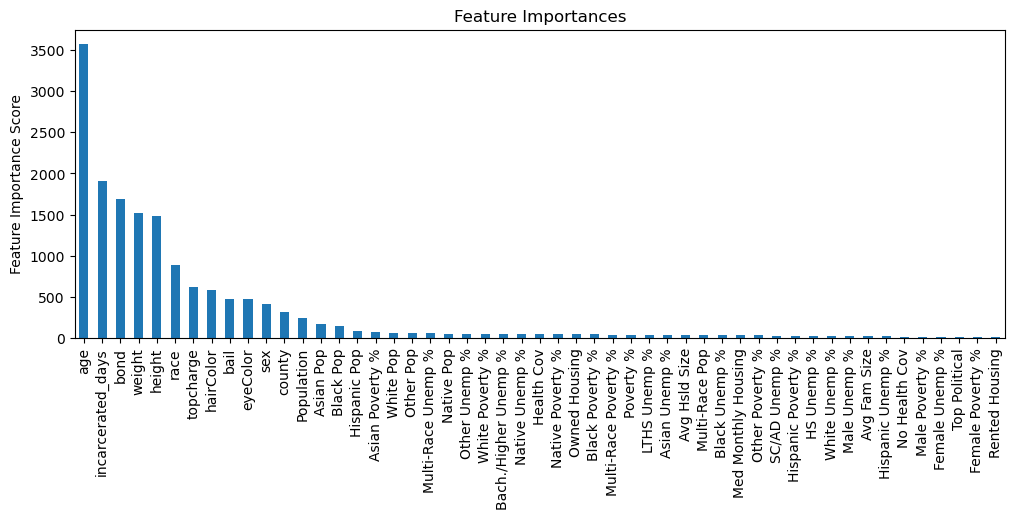

In [36]:
predictors = [x for x in df.columns if x not in not_selected] 
X = df[predictors]
y = df['time_gap']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a DMatrix with enable_categorical=True
dtrain = xgb.DMatrix(X_train, label = y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label = y_test, enable_categorical=True)

xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=0,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 enable_categorical = True)

modelfit(xgb1, dtrain, predictors, dtest = dtest)

### Common strong predictors:

- age
- sex
- incarcerated_days
- bond
- race
- topcharge
- county
- Population (Asian Pop, White Pop, Black Pop etc.)
- Poverty %
- Unemployment %

### Differences in strong predictors:

- Linear and Lasso Regression: Includes features like age, sex, height, weight, bail, incarcerated_days, county, population, poverty % and unemployment %

- XGBoost: Puts more emphasis on features like age, incarcerated_days, bond, weight, height, topcharge, race, bail, sex, county, population and unemployment %

It seems that while some features are common strong predictors, there are differences in the emphasis placed on certain features by the linear and Lasso regression compared to XGBoost models. The choice of strong predictors can be influenced by the modeling technique and the inherent characteristics of the data. Linear and Lasso regression focuses on coefficients and their statistical significance, while XGBoost considers the importance of features based on their contribution to the model's predictive performance (the ability of variables in making better prediction)

Note that: The importance score of a feature in XGBoost reflects its contribution to the model's predictive performance. A low score doesn't necessarily mean it's a weak predictor; it might indicate that the feature doesn't play a crucial role in the specific context of the model or that its contribution is overshadowed by other more influential features.